<a href="https://colab.research.google.com/github/alouwyck/vives-deep-learning/blob/main/topic18/4_Backpropagation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

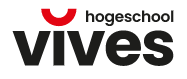<br>


**DEEP LEARNING**<br>
Academiejaar 2022-2023<br>
Andy Louwyck

---



---



# BACKPROPAGATION

Deze notebook volgt op de notebook die hoofdstuk 5 samenvat uit het boek "Grokking Deep Learning. De inhoud is gebaseerd op de les over neurale netwerken van het vak "Data Science II" van de opleiding Toegepaste Informatica aan de Karel De Grote Hogeschool, gegeven in het academiejaar 2019-2020 door Wouter Deketelaere. Op YouTube vind je een interessante screencast die deze les samenvat: https://youtu.be/-fU-1E-R-xA. De voorbeeldcode is in R geschreven; wij gebruiken uiteraard Python.

## Gradient descent learning: neural networks can be stacked!

Dit staat niet in het boek maar laten we toch eens proberen om ook gradient descent toe te passen op het voorbeeldje met een verborgen tussenlaag.

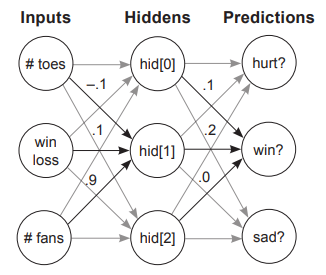

**Herhaling**: Het model heeft 2 lagen.

In laag 1 berekenen we adhv de input $x_j$ een tussentijds resultaat $h_i$:

> $\begin{cases} h_1 = w_{111}x_1 + w_{112}x_2 + w_{113}x_3 \\
h_2 = w_{121}x_1 + w_{122}x_2 + w_{123}x_3 \\
h_3 = w_{131}x_1 + w_{132}x_2 + w_{133}x_3 \end{cases}$

Of gebruik makend van het sommatieteken en indexvariabelen $i$ en $j$:

> $h_i = \sum_{j=1}^3 w_{1ij}x_j \mbox{  met i= 1, 2, 3}$

In laag 2 gebruiken we output $h_i$ als input om de voorspellingen $y_i$ te krijgen:

> $\begin{cases} y_1 = w_{211}h_1 + w_{212}h_2 + w_{213}h_3 \\
y_2 = w_{221}h_1 + w_{222}h_2 + w_{223}h_3 \\
y_3 = w_{231}h_1 + w_{232}h_2 + w_{233}h_3 \end{cases}$

Of opnieuw gebruik makend van het sommatieteken:

> $y_i = \sum_{j=1}^3 w_{2ij}h_j \mbox{  met i= 1, 2, 3}$

We kunnen de uitdrukking van laag 1 hierin substitueren om ons uiteindelijke model te krijgen:

> $y_i = \sum_{j=1}^3 (w_{2ij}\sum_{k=1}^3w_{1jk}x_k) \mbox{  met i= 1, 2, 3}$



**Nieuw**: We gaan nu ook de squared error berekenen en de 18 gewichten aanpassen aan de hand van de gradiënt.

In [ ]:
# inwendig product
def weighted_sum(a, b):
    assert(len(a) == len(b))
    output = 0
    for i in range(len(a)):
        output += a[i] * b[i]
    return output

# inwendig product van elke rij van een matrix en een vector
def vector_matrix_mult(vector, matrix):
    assert(len(vector) == len(matrix))
    output = []
    for row in matrix:
        output.append(weighted_sum(vector, row))
    return output

def neural_network(input, weights):
    hidden = vector_matrix_mult(input, weights[0])  # laag 1
    prediction = vector_matrix_mult(hidden, weights[1])  # laag 2
    return hidden, prediction  # we hebben nu ook de output van de hidden laag nodig!

def squared_error(labels, predictions):
    errors = []
    for i in range(len(labels)):
        errors.append((predictions[i] - labels[i]) ** 2)
    return errors

In [ ]:
# gewichten
                        #toes   #win  #fans
weights_input_hidden = [[ 0.1,   0.2,  -0.1],  # hid[0]
                        [-0.1,   0.1,   0.9],  # hid[1]
                        [ 0.1,   0.4,   0.1]]  # hid[2]

                       #hid[0] #hid[1] #hid[1]
weights_hidden_pred  = [[ 0.3,   1.1,  -0.3],  # hurt?
                        [ 0.1,   0.2,   0.0],  # win?
                        [ 0.0,   1.3,   0.1]]  # sad?

weights = [weights_input_hidden, weights_hidden_pred]  # 3D array

# input
toes = [8.5, 9.5, 9.9, 9.0]
win_loss = [0.65, 0.8, 0.8, 0.9]
nfans = [1.2, 1.3, 0.5, 1.0]

# labels
hurt = [0.1, 0.0, 0.0, 0.1]  # hoeveel % van de spelers is geblesseerd na de match?
win = [1, 1, 0, 1]           # match gewonnen?
sad = [0.1, 0.0, 0.1, 0.2]   # hoeveel % van de spelers is niet blij na de match?

# voorspellingen en fouten
_, predictions = neural_network([toes[0], win_loss[0], nfans[0]], weights)  # we nemen enkel het eerste datapunt
errors = squared_error([hurt[0], win[0], sad[0]], predictions)

print(predictions)
print(errors)

[0.21350000000000002, 0.14500000000000002, 0.5065]
[0.012882250000000005, 0.7310249999999999, 0.16524224999999998]


De code om de gewichten aan te passen is minder evident - vandaar dat het niet in het boek staat ;-)

We hebben opnieuw het uitwendig product nodig om de gewichten aan te passen. Die gewichten zitten nu in een 3D matrix omdat we ook gewichten nodig hebben voor de tussenlaag. De shape van de array met gewichten is dus 2 x 3 x 3. De aanpassingsfactoren voor die gewichten vormen samen ook een 2 x 3 x 3 matrix. Ze worden als volgt berekend:

> `weight_deltas[0] = outer_product(inputs, deltas[0])`

> `weight_deltas[1] = outer_product(hidden, deltas[1])`

We zien dat er ook delta's zijn voor elke laag. De delta's berekenen van de laatste laag gebeurt op dezelfde manier als voor de netwerken zonder tussenlaag:

> `deltas[1] = predictions - labels`

De delta's voor de tussenlaag vinden we door toepassing van de kettingregel (zie verder):

> `deltas[0] = vector_matrix_mult(deltas[1], transpose(weights[1]))`

We moeten dus ook nog een functie `transpose` definiëren om de gewichtenmatrix van de tussenlaag te transponeren.

In [ ]:
# outer product tussen 2 vectoren
def outer_product(vector1, vector2):
    out = []
    for i in range(len(vector1)):
        out.append([])
        for j in range(len(vector2)):
            out[i].append(vector1[i] * vector2[j])
    return out

# matrix transponeren
def transpose(matrix):
    m, n = len(matrix), len(matrix[0])
    t_matrix = []
    for j in range(n):
        t_matrix.append([])
        for i in range(m):
            t_matrix[j].append(matrix[i][j])
    return t_matrix

# gewichten aanpassen
from copy import deepcopy

def adapt_weights(inputs, labels, weights, alpha=0.01):
    hidden, predictions = neural_network(inputs, weights)  # voorspelling
    deltas = [[]]
    for i in range(len(labels)):
        deltas[0].append(predictions[i] - labels[i])  # deltas voor outputlaag: verschil tussen voorspelling en label
    deltas.insert(0, vector_matrix_mult(deltas[0], transpose(weights[1])))  # kettingregel: deltas voor tussenlaag
    weight_deltas = []
    weight_deltas.append(outer_product(inputs, deltas[0]))  # weight_deltas laag 1
    weight_deltas.append(outer_product(hidden, deltas[1]))  # weight_deltas laag 2
    weights = deepcopy(weights)  # deep copy maken! want lists in list!
    for i in range(len(weights)):
        for j in range(len(weights[i])):
            for k in range(len(weights[i][j])):
                weights[i][j][k] -= alpha * weight_deltas[i][j][k]  # nieuwe weights
    return weights

In [ ]:
adapt_weights(inputs=[toes[0], win_loss[0], nfans[0]],
              labels=[hurt[0], win[0], sad[0]], weights=weights)  # enkel eerste datapunt

[[[0.10437325, 0.15900450000000002, -0.10056100000000001],
  [-0.099665575, 0.09686505000000001, 0.8999571000000001],
  [0.10061740000000001, 0.3942124, 0.0999208]],
 [[0.2990239, 1.107353, -0.3034959],
  [0.09966517500000001, 0.20252225000000001, -0.0011991749999999998],
  [-0.00139605, 1.3105165, 0.09500005]]]

**Opdracht**: Overloop nu de 4 datapunten en pas de gewichten achtereenvolgens aan. Wat zijn je uiteindelijke voorspellingen en fouten?

In [ ]:
for i in range(len(win_loss)):

    inputs = [toes[i], win_loss[i], nfans[i]]
    labels = [hurt[i], win[i], sad[i]]

    _, predictions = neural_network(inputs, weights)  # predict
    errors = squared_error(labels, predictions)  # compare
    weights = adapt_weights(inputs, labels, weights)  # learn

    print("Data point", i)
    print("\tpredictions:", predictions)
    print("\tsquared errors:", errors)
    #print("\tweights:", weights)

Data point 0
	predictions: [0.21350000000000002, 0.14500000000000002, 0.5065]
	squared errors: [0.012882250000000005, 0.7310249999999999, 0.16524224999999998]
Data point 1
	predictions: [0.20308879763949578, 0.157671884281862, 0.5256870087896279]
	squared errors: [0.04124505972665606, 0.7095166545292689, 0.27634683121018633]
Data point 2
	predictions: [-0.6145119153446335, 0.008145578019887918, -0.4966166876865438]
	squared errors: [0.37762489410052996, 6.635044127808117e-05, 0.35595147202606303]
Data point 3
	predictions: [0.07751950209826147, 0.1318883676636329, 0.2801294531977131]
	squared errors: [0.0005053727859100706, 0.7536178061977118, 0.006420729269764492]


**Opdracht**: Schrijf alle code opnieuw (inclusief de gegeven functies) en maak deze keer gebruik van NumPy arrays en gevectoriseerde expressies.

In [ ]:
import numpy as np

# gewichten
                        #toes   #win  #fans
weights_input_hidden = [[ 0.1,   0.2,  -0.1],  # hid[0]
                        [-0.1,   0.1,   0.9],  # hid[1]
                        [ 0.1,   0.4,   0.1]]  # hid[2]

                       #hid[0] #hid[1] #hid[1]
weights_hidden_pred  = [[ 0.3,   1.1,  -0.3],  # hurt?
                        [ 0.1,   0.2,   0.0],  # win?
                        [ 0.0,   1.3,   0.1]]  # sad?

weights = [weights_input_hidden, weights_hidden_pred]  # 3D array

# input
toes = [8.5, 9.5, 9.9, 9.0]
win_loss = [0.65, 0.8, 0.8, 0.9]
nfans = [1.2, 1.3, 0.5, 1.0]

# labels
hurt = [0.1, 0.0, 0.0, 0.1]  # hoeveel % van de spelers is geblesseerd na de match?
win = [1, 1, 0, 1]           # match gewonnen?
sad = [0.1, 0.0, 0.1, 0.2]   # hoeveel % van de spelers is niet blij na de match?

# omzetten naar arrays
inputs = np.array([toes, win_loss, nfans]).T  # 4 x 3
labels = np.array([hurt, win, sad]).T  # 4 x 3
weights = np.array(weights)
alpha = 0.01

In [ ]:
for i in range(inputs.shape[0]):
    # predict
    hidden = np.dot(weights[0], inputs[i, :])
    predictions = np.dot(weights[1], hidden)
    # compare
    deltas = predictions - labels[i, :]
    errors = np.square(deltas)
    # learn
    deltas_hidden = np.dot(weights[1].T, deltas)
    weights[0] -= alpha * np.outer(inputs[i, :], deltas_hidden)
    weights[1] -= alpha * np.outer(hidden, deltas)

    print("Data point", i)
    print("predictions:", predictions)
    print("squared errors:", errors)
    #print("weights:")
    #print(weights)
    print()

Data point 0
predictions: [0.2135 0.145  0.5065]
squared errors: [0.01288225 0.731025   0.16524225]

Data point 1
predictions: [0.2030888  0.15767188 0.52568701]
squared errors: [0.04124506 0.70951665 0.27634683]

Data point 2
predictions: [-0.61451192  0.00814558 -0.49661669]
squared errors: [3.77624894e-01 6.63504413e-05 3.55951472e-01]

Data point 3
predictions: [0.0775195  0.13188837 0.28012945]
squared errors: [5.05372786e-04 7.53617806e-01 6.42072927e-03]



**Uitdaging**: Lukt het ook in dit geval om de gewichten in één keer aan te passen door alle datapunten samen te nemen in één **batch**? Bereken ook de **Mean Squared Error** (MSE).

In [ ]:
import numpy as np

# gewichten
                        #toes   #win  #fans
weights_input_hidden = [[ 0.1,   0.2,  -0.1],  # hid[0]
                        [-0.1,   0.1,   0.9],  # hid[1]
                        [ 0.1,   0.4,   0.1]]  # hid[2]

                       #hid[0] #hid[1] #hid[1]
weights_hidden_pred  = [[ 0.3,   1.1,  -0.3],  # hurt?
                        [ 0.1,   0.2,   0.0],  # win?
                        [ 0.0,   1.3,   0.1]]  # sad?

weights = [weights_input_hidden, weights_hidden_pred]  # 3D array

# input
toes = [8.5, 9.5, 9.9, 9.0]
win_loss = [0.65, 0.8, 0.8, 0.9]
nfans = [1.2, 1.3, 0.5, 1.0]

# labels
hurt = [0.1, 0.0, 0.0, 0.1]  # hoeveel % van de spelers is geblesseerd na de match?
win = [1, 1, 0, 1]           # match gewonnen?
sad = [0.1, 0.0, 0.1, 0.2]   # hoeveel % van de spelers is niet blij na de match?

# omzetten naar arrays
inputs = np.array([toes, win_loss, nfans]).T  # 4 x 3
labels = np.array([hurt, win, sad]).T  # 4 x 3
weights = np.array(weights)
alpha = 0.01

In [ ]:
# predict
hidden = np.dot(weights[0], inputs.T)
predictions = np.dot(weights[1], hidden)

# compare
deltas = predictions - labels.T
errors = np.square(deltas)
MSEs = np.mean(errors, axis=0)
deltas_hidden = np.dot(weights[1].T, deltas)

# learn
weights[0] -= alpha * np.dot(deltas_hidden, inputs)
weights[1] -= alpha * np.dot(deltas, hidden.T)

print("predictions:")
print(predictions.T)
print("\nsquared errors:")
print(errors.T)
print("\nMSEs:")
print(MSEs)
#print("\nnew weights:")
#print(weights)

predictions:
[[ 0.2135  0.145   0.5065]
 [ 0.204   0.158   0.53  ]
 [-0.584   0.018  -0.462 ]
 [-0.015   0.116   0.253 ]]

squared errors:
[[1.2882250e-02 7.3102500e-01 1.6524225e-01]
 [4.1616000e-02 7.0896400e-01 2.8090000e-01]
 [3.4105600e-01 3.2400000e-04 3.1584400e-01]
 [1.3225000e-02 7.8145600e-01 2.8090000e-03]]

MSEs:
[0.30304983 0.34382667 0.21907467 0.26583   ]


## The chain rule

Om de gewichten aan te passen moeten we de kettingregel toepassen (https://en.wikipedia.org/wiki/Chain_rule). Deze regel zegt eenvoudigweg dat de afgeleide van een samengestelde functie (i.e. een functie van een functie) gelijk is aan het product van de afgeleiden van die afzonderlijke functies.

Voor diegenen die in de wiskunde geïnteresseerd zijn, leggen we uit hoe die regel werkt. Neem een samengestelde functie die bestaat uit de functie $g$ waarop dan de functie $f$ wordt toegepast:

> $z = f(y)$

met

> $y = g(x)$

Als we $y$ in $f(y)$ substitueren, krijgen we:

> $z = f(g(x)) = (f \circ g)(x)$

Het bolletje $\circ$ betekent dus "na": je evalueert $f$ na $g$.

De kettingregel zegt dat de afgeleide van $h$ naar $x$ als volgt kan berekend worden:

> $\frac{dz}{dx} = \frac{dz}{dy} \frac{dy}{dx}$

Voorbeeldje:

> $z = (x-2)^2$

Dat kunnen we ook schrijven als:

> $z = y^2$ met $y = x-2$

Om de afgeleide van $z$ naar $x$ te vinden, moeten we dus eerst $z$ afleiden naar $y$ en dan $y$ afleiden naar $x$:

> $\frac{dz}{dy} = 2y$ en $\frac{dy}{dx} = -2$

Waaruit volgt dat:

> $\frac{dz}{dx} = \frac{dz}{dy} \frac{dy}{dx} = 2y.(-2) = -4y = -4(x-2) = 8-4x$

Dit is ook hoe we de gradiënt hebben berekend van de squared error $\epsilon$:

> $\epsilon = \delta^2 = (\hat{y} - y)^2 = (wx - y)^2$

Met $\hat{y}$ de voorspelling en $y$ het overeenkomstige label.

Eigenlijk willen we de error $\epsilon$ afleiden naar het gewicht $w$:

> $\frac{d\epsilon}{dw} = \frac{d\epsilon}{d\delta} \frac{d\delta}{dw} = 2 \delta x$

Of zoals we dat in code hebben geschreven:

> `weight_delta = 2 * delta * input = 2 * (prediction - goal) * input`

De 2 laten we vallen omdat de `weight_delta` wordt vermenigvuldigd met de learning rate. Soms deelt men ook de fout $\epsilon$ door 2 om het wiskundig correct te houden.




## Activation functions

We weten ondertussen dat een artificieel neuraal netwerk uit bestaat knopen bestaat, ook wel neuronen genaamd. Neuronen zijn eigenlijk hersencellen. Omdat artificiële neurale netwerken geïnspireerd zijn door onze hersenen, is er  een gelijkenis tussen artificiële neuronen en biologische neuronen: beiden verzwakken of versterken de signalen die ze ontvangen van andere neuronen om ze vervolgens door te sturen naar de volgende neuronen.

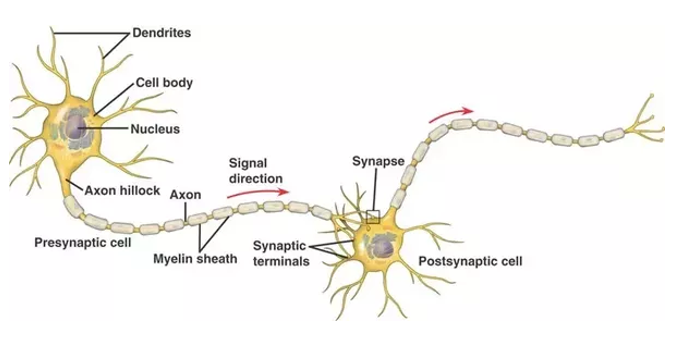

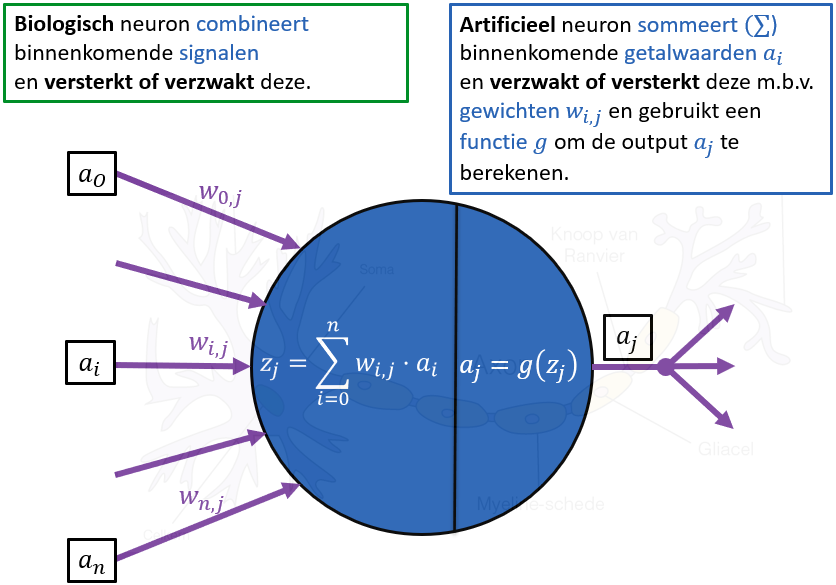

Op die figuur zien we dat een gewogen som van de input van het neuron wordt genomen. Die gewogen som wordt dan getransformeerd door een functie $g$. Deze functie noemen we de activatiefunctie. Denk bijvoorbeeld aan de Heaviside stapfunctie bij het perceptron of de sigmoïdefunctie bij logistic regression. In de figuur hieronder zie je nog andere activatiefuncties.

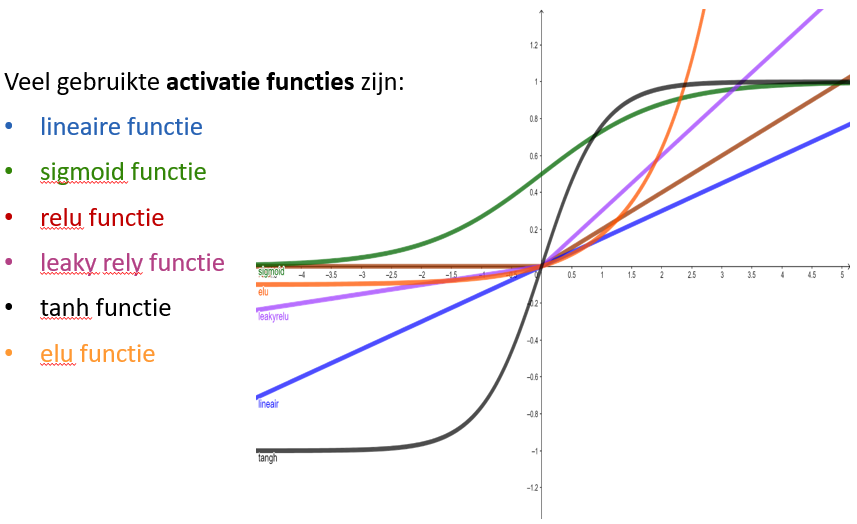

De rectifier of ReLU-functie (= Rectified Linear Unit), die we in de ConvNets hebben toegepast, beeldt alle negatieve waarden af op nul, en laat de positieve waarden ongewijzigd:

> $ReLu(x) = max(0, x)$

De ReLU-functie zal dus gewichten op nul zetten en heeft dus een gelijkaardig effect als een drop-out laag.

Dit is de grafiek van de ReLU-functie:

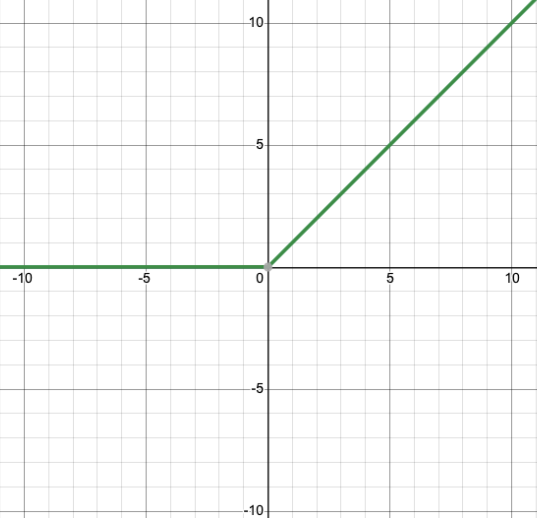

Tot nu toe hebben we als activatiefunctie $a = g(z) = z$ gebruikt. M.a.w. de gewogen som werd niet getransformeerd. Laten we nu eens het volledige backpropagation algoritme bekijken waarbij we ook een activatiefunctie definiëren.

## The backpropagation algorithm

**Backpropagation** is het algoritme om de gewichten van de verschillende lagen aan te passen door toepassing van de kettingregel. We noemen dit "backpropagation" omdat we starten bij de outputlaag en "terug" gaan naar de inputlaag. Die stap noemen we de **backward pass**. De **forward pass** is de stap die ervoor komt en waarin we de inputdata door de lagen laten gaan om de output met voorspellingen te krijgen.

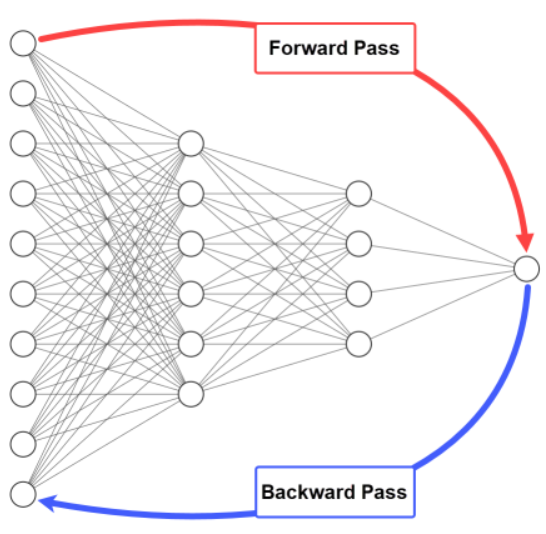

In matrixnotatie ziet het algoritme er zo uit:

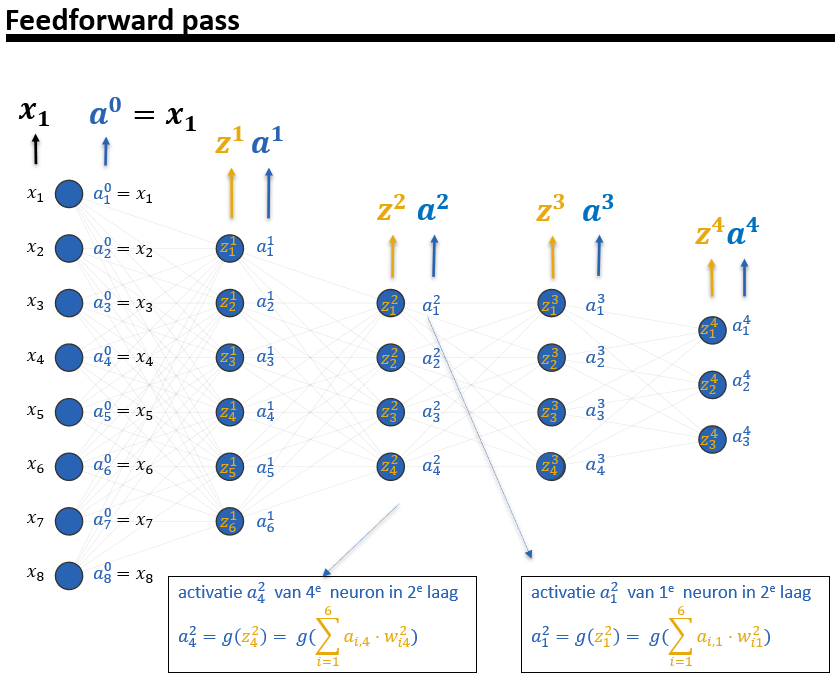

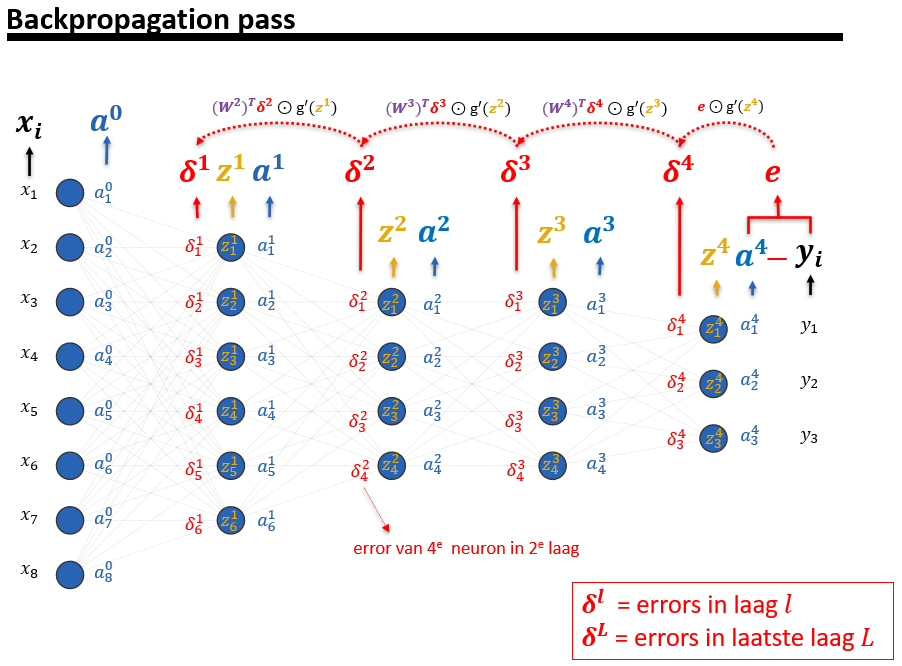

## Matrix operations

Laten we nog eens de verschillende matrixbewerkingen herhalen.

Het scalair product of inwendig product van twee vectoren:

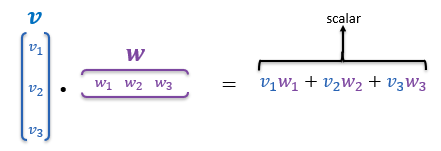

Kan ook toegepast worden op een matrix **$W$** en een vector **$v$** waarbij we dan elke rij van **$W$** combineren met **$v$**:

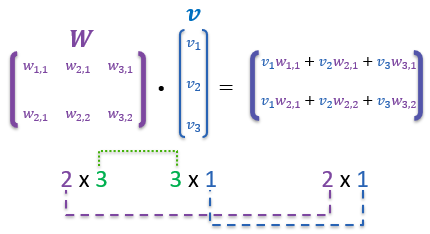

Het **uitwendig product** van twee vectoren:

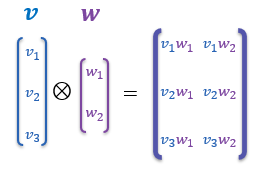

**Het Hadamardproduct of elementgewijze vermenigvuldiging** tussen 2 vectoren of 2 matrices:

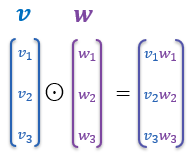

Tenslotte hebben we nog de **getransponeerde matrix**:

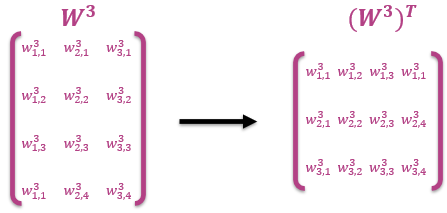

**Merk op!**

Inwendig en uitwendig product zijn in feite speciale gevallen van matrixvermenigvuldiging. Bij het inwendig product is de eerste vector een rijvector en de tweede een kolomvector. Bij het uitwendigproduct is de eerste vector een kolomvector en de tweede een rijvector.

In [ ]:
import numpy as np

v = np.arange(1, 4)
w = np.arange(4, 7)

print("v:", v)
print("w:", w)

v: [1 2 3]
w: [4 5 6]


In [ ]:
print("inner:")
print(np.inner(v, w))
print()
print("outer:")
print(np.outer(v, w))

inner:
32

outer:
[[ 4  5  6]
 [ 8 10 12]
 [12 15 18]]


In [ ]:
# met de dot-functie:
print("inner:")
print(np.dot(v, w))
print()
print("outer:")
print(np.dot(v.reshape(-1, 1), w.reshape(1, -1)))  # v -> kolom en w -> rij

inner:
32

outer:
[[ 4  5  6]
 [ 8 10 12]
 [12 15 18]]


## A neural network with multiple inputs and outputs and one hidden layer

We gaan het backpropagation algoritme nu toepassen op een eenvoudig gelaagd netwerk met 1 verborgen tussenlaag. De inputdata bevatten 7 elementen of features, de output bestaat uit 3 elementen. De inputlaag moet dus 7 knopen hebben, de outputlaag 3. De tussenlaag geven we 5 neuronen.

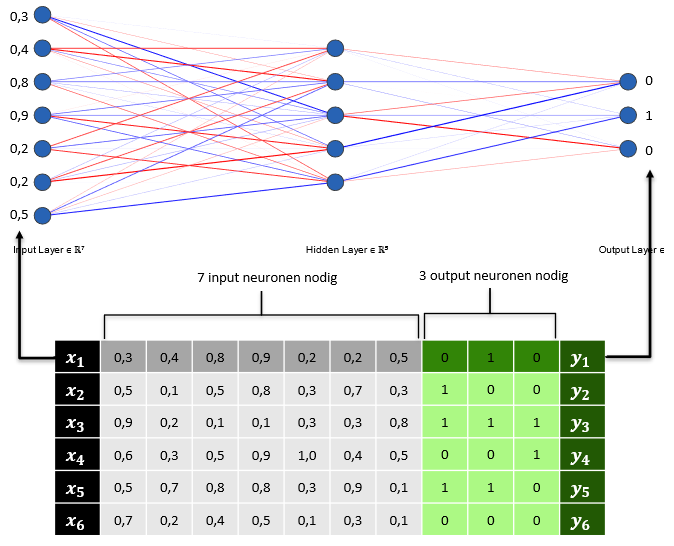

In totaal hebben we 6 examples in onze dataset. Je kan die inlezen uit het bestand "backpropagation.txt". Splits de dataset al op in een matrix `X` met de inputwaarden, en een matrix `Y` met de outputwaarden.

In [ ]:
import pandas as pd
import numpy as np

data = pd.read_csv("backpropagation.txt", header=None)
X = data.iloc[:, 0:7].values
Y = data.iloc[:, 7:-1].values
print(X)
print(Y)

[[0.3 0.4 0.8 0.9 0.2 0.2 0.5]
 [0.5 0.1 0.5 0.8 0.3 0.7 0.3]
 [0.9 0.2 0.1 0.1 0.3 0.3 0.8]
 [0.6 0.3 0.5 0.9 1.  0.4 0.5]
 [0.5 0.7 0.8 0.8 0.3 0.9 0.1]
 [0.7 0.2 0.4 0.5 0.1 0.3 0.1]]
[[0 1 0]
 [1 0 0]
 [1 1 1]
 [0 0 1]
 [1 1 0]
 [0 0 0]]


Schrijf nu 2 functies voor de sigmoïde activatiefunctie $g(z)$ en de afgeleide van die functie $g'(z)$. De vergelijkingen zijn:

> $g(z) = \frac{1}{1+e^{-z}}$

> $g'(z) = \frac{dg}{dz} = g(z)(1-g(z))$

In [ ]:
g = lambda z: 1 / (1 + np.exp(-z))
dgdz = lambda z: g(z) * (1 - g(z))

We starten voor de eenvoud met het eerste datapunt. Stop input en output in variabelen `x` en `y`, resp.

In [ ]:
i = 0
x = X[i, :]
y = Y[i, :]

print(x)
print(y)

[0.3 0.4 0.8 0.9 0.2 0.2 0.5]
[0 1 0]


Maak nu twee matrices aan met gewichten. Elke verbinding tussen twee nodes wordt gekenmerkt door een gewicht. De eerste matrix `W1` zijn de gewichten tussen de inputlaag en de verborgen laat en moet dus 5 x 7 gewichten bevatten. De tweede matrix `W2` zijn de gewichten tussen de verborgen laag en de outputlaag en moet dus een 3 x 5 matrix zijn. Initialiseer de matrices met willekeurige waarden die standaardnormaal verdeeld zijn. Gebruik hiervoor de functie `np.random.randn`.  

In [ ]:
W1 = np.random.randn(5, 7)
W2 = np.random.randn(3, 5)

Voer nu één *forward pass* uit:

1.   $a_0 = x$
2.   $z_1 = W_1 . a_0$ (inwendig product)
3.   $a_1 = g(z_1)$  (sigmoïdefunctie toepassen)
4.   $z_2 = W_2 . a_1$  (inwendig product)
5.   $a_2 = g(z_2)$  (sigmoïdefunctie toepassen)

De vector $a_2$ is de output (de voorspellingen)



In [ ]:
a0 = x
z1 = np.dot(W1, a0)
a1 = g(z1)
z2 = np.dot(W2, a1)
a2 = g(z2)
a2

array([0.17641826, 0.71911587, 0.85521846])

Voer nu één *backward pass* uit:

1.   $e = (a_2-y)$
2.   $\delta_2 = e \circ g'(z_2)$  (Hadamardproduct en afgeleide van sigmoïdefunctie)
3.   $\delta_1 = [(W_2)^T . \delta_2] \circ g'(z_1)$ (inwendig product en Hadamardproduct)
4.   $\Delta W_1 = \delta_1 \otimes a_0$ (uitwendig product)
5.   $\Delta W_2 = \delta_2 \otimes a_1$ (uitwendig product)



In [ ]:
e = a2 - y
d2 = e * dgdz(z2)
d1 = np.dot(W2.T, d2) * dgdz(z1)
dW1 = np.outer(d1, a0)
dW2 = np.outer(d2, a1)

Pas tenslotte de gewichten aan:

1.   $W_1 = W_1 - \alpha \Delta W_1$
2.   $W_2 = W_2 - \alpha \Delta W_2$

Hyperparameter $\alpha$ is de learning rate. Neem die gelijk aan 0.1.

In [ ]:
alpha = 0.1
W1 -= alpha * dW1
W2 -= alpha * dW2

Merk op dat we dit algoritme ook in ons eerste voorbeeld hebben toegepast. Alleen maakten we daar geen gebruik van een activatiefunctie, of anders gezegd: $g(z) = z$ en $g'(z) = 1$.

Schrijf nu een functie `backpropagation` die deze stappen groepeert zodat je die kan toepassen op alle datapunten.

In [ ]:
def backpropagation(x, y, W1, W2, g, dgdz, alpha):
    # forward
    a0 = x
    z1 = np.dot(W1, a0)
    a1 = g(z1)
    z2 = np.dot(W2, a1)
    a2 = g(z2)
    # backward
    e = a2 - y
    d2 = e * dgdz(z2)
    d1 = np.dot(W2.T, d2) * dgdz(z1)
    dW1 = np.outer(d1, a0)
    dW2 = np.outer(d2, a1)
    # new W1 and W2
    return W1 - alpha * dW1, W2 - alpha * dW2

Schrijf een functie `predict` die voor alle datapunten `X` een voorspelling maakt gegeven de gewichten `W1` en `W2` en de activatiefunctie `g`.

In [ ]:
def predict(X, W1, W2, g):
    A1 = g(np.dot(W1, X.T))
    return g(np.dot(W2, A1)).T

Schrijf ook een functie om de MSE te berekenen van alle datapunten `X` gegeven de output `Y`, de gewichten `W1` en `W2` en de activatiefunctie `g`. Let op! Er zijn 3 outputs, dus je moet 3 MSE waarden berekenen!

In [ ]:
def MSE(X, Y, W1, W2, g):
    return np.mean(np.square(predict(X, W1, W2, g) - Y), axis=0)

Doorloop nu willekeurig alle datapunten (= 1 epoch) en pas je functie `backpropagation` toe. Herhaal dat 5000 keer (=`num_epochs`). Bereken ook na elke epoch de MSE en hou die bij.

In [ ]:
import random

# hyperparameters
alpha = 0.1
num_epochs = 5000

# gewichten initialiseren
W1 = np.random.randn(5, 7)
W2 = np.random.randn(3, 5)
MSEs = []

# indices van datapunten
idx = list(range(X.shape[0]))

# outer loop: epochs
for _ in range(num_epochs):

    # inner loop: datapunten willekeurig doorlopen
    random.shuffle(idx)
    for i in idx:

        # backpropagation toepassen
        W1, W2 = backpropagation(x=X[i, :], y=Y[i, :], W1=W1, W2=W2, g=g, dgdz=dgdz, alpha=alpha)

    # MSE
    MSEs.append(MSE(X, Y, W1, W2, g))

MSEs = np.asarray(MSEs)

Plot de MSE uit van de 3 outputs. Convergeert je model?

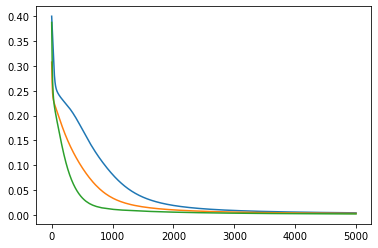

In [ ]:
import matplotlib.pyplot as plt

plt.plot(MSEs);

**UITDAGING**: Slaag je er ook hier in om het backpropagation algoritme uit te breiden zodat het ook de gewichten kan updaten adhv alle datapunten (= full batch)?

In [ ]:
def backpropagation_batch(X, Y, W1, W2, g, dgdz, alpha):
    # forward
    A0 = X.T
    Z1 = np.dot(W1, A0)
    A1 = g(Z1)
    Z2 = np.dot(W2, A1)
    A2 = g(Z2)
    # backward
    E = A2 - Y.T
    D2 = E * dgdz(Z2)
    D1 = np.dot(W2.T, D2) * dgdz(Z1)
    dW1 = np.dot(D1, A0.T)
    dW2 = np.dot(D2, A1.T)
    # new W1 and W2
    return W1 - alpha * dW1, W2 - alpha * dW2

In [ ]:
import random

# hyperparameters
alpha = 0.1
num_epochs = 5000

# gewichten initialiseren
W1 = np.random.randn(5, 7)
W2 = np.random.randn(3, 5)
MSEs = []

# indices van datapunten
idx = list(range(X.shape[0]))

# outer loop: epochs
for _ in range(num_epochs):

    # batch shuffelen
    random.shuffle(idx)

    # backpropagation in batch toepassen
    W1, W2 = backpropagation_batch(X=X[idx, :], Y=Y[idx, :], W1=W1, W2=W2, g=g, dgdz=dgdz, alpha=alpha)

    # MSE
    MSEs.append(MSE(X, Y, W1, W2, g))

MSEs = np.asarray(MSEs)

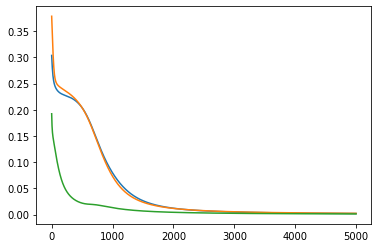

In [ ]:
import matplotlib.pyplot as plt

plt.plot(MSEs);

Herinner je dat er wat die batches betreft 3 mogelijkheden zijn:

*   **Stochastic Gradient Descent**: de gewichten worden geüpdatet adhv 1 datapunt
*   **Full (Batch) Gradient Descent**: de gewichten worden geüpdated adhv de volledige dataset
*   **(Mini-)Batch Gradient Descent**: de gewichten worden geüpdated adhv een (mini-)batch van datapunten.

De laatste optie is de interessantste omdat het sneller en stabieler is dan elk datapunt afzonderlijk overlopen, maar het heeft minder geheugen nodig dan wanneer je de volledige dataset gebruikt om de gewichten te updaten. Bij zeer grote datasets is het zelfs niet mogelijk om de volledige dataset in het geheugen te laden.





**OEFENING**: Train nu het model met mini-batches van size 3. Definieer ook effectief de variabele `batch_size = 3` zodat je code generiek is!

In [ ]:
import random

# hyperparameters
alpha = 0.1
num_epochs = 5000
batch_size = 3

# aantal samples
nsamples = X.shape[0]

# gewichten initialiseren
W1 = np.random.randn(5, 7)
W2 = np.random.randn(3, 5)
MSEs = []

# indices van datapunten
idx = np.array(range(nsamples))  # numpy array!

# outer loop: epochs
for _ in range(num_epochs):

    # batch shuffelen
    random.shuffle(idx)

    # initialize mini-batch indices
    b = np.arange(batch_size)

    # inner loop: mini-batches
    for i in range(nsamples // batch_size):  # integer division!

        # backpropagation voor mini-batch toepassen
        W1, W2 = backpropagation_batch(X=X[idx[b], :], Y=Y[idx[b], :],
                                       W1=W1, W2=W2, g=g, dgdz=dgdz, alpha=alpha)
        # update mini-batch indices
        b += batch_size

    # MSE
    MSEs.append(MSE(X, Y, W1, W2, g))

MSEs = np.asarray(MSEs)

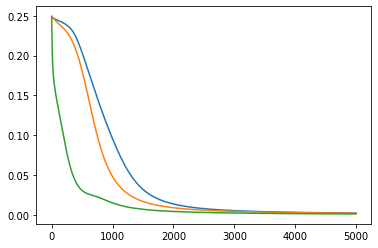

In [ ]:
import matplotlib.pyplot as plt

plt.plot(MSEs);

## Bias

Tot nu toe hebben we in onze voorbeelden nog geen bias toegevoegd. Herinner je dat de bias de constante term is in de lineaire vergelijking.

Herinner je dat het eenvoudigste neurale netwerk met 1 input en 1 output die we kunnen opstellen, de volgende vergelijking had:

> $y = wx$

In deze vergelijking werd de bias-term weggelaten. Voegen we die term toe, dan wordt de algemene vergelijking van het model:

> $y = wx + b$

Dat is ook de algemene vergelijking van een rechte en in dat geval is die constante term de intercept.

In ML Fundamentals hebben we $-b$ beschouwd, de negatieve intercept, maar omdat $b$ een parameter is die moet bepaald worden door het backpropagation algoritme maakt het in principe niet uit of je de constante term optelt of aftrekt.

De bias-term kunnen we eenvoudig in rekening brengen door die aan onze vector of matrix met gewichten toe te voegen. Vandaar ook dat men dikwijls de bias-term met het symbool $w_0$ aanduidt:

> $y = w_0 + w_1x_1 + w_2x_2 + ...$

We moeten dan natuurlijk wel onze features met een extra element of kolom gelijk aan 1 uitbreiden:

> $x_0 = 1$

Op die manier kunnen we onze vergelijking schrijven als:

> $y = w_0x_0 + w_1x_1 + w_2x_2 + ...$ (met $x_0=1$)

Of gebruik makend van het sommatieteken:

> $y = \sum_{i=0}^n w_ix_i$ (met $x_0 = 1$)

Laten we dat eens naar NumPy code vertalen:

In [ ]:
import numpy as np

# Vector met features van 1 datapunt
# Het eerste element is x0 = 1! Dan heb je x1 = 5 en x2 = 3
x = np.array([1, 5, 3])

# Vector met gewichten
# Het eerste element is de bias w0 = 2! Dan heb je w1 = -1 en w2 = 3
w = np.array([2, -1, 3])
w_ = np.array([-1, 3])

# De voorspelling: inwendig product nemen
y = np.inner(x, w)
print(y)

6


Hetzelfde principe kunnen we toepassen voor een matrix met verschillende datapunten:

In [ ]:
# Matrix met features van 2 datapunt
# De eerste kolom is x0 = 1!
X = np.array([[1, 5, 3], [1, -2, 7]])

# Vector met gewichten
W = np.array([2, -1, 3])

# De voorspellingen:
Y = np.inner(X, w)
print(Y)

[ 6 25]


Wanneer we nu het backpropagation algoritme willen aanpassen zodat ook bij elke gewogen som een bias term wordt opgeteld, dan moeten we het volgende doen:

- De inputmatrix `X` krijgt dus vooraan een extra kolom met enen. Matrix `A0` is de transpose van de uitgebreide matrix `X` en krijgt dus bovenaan automatisch een rij met enen.
- De matrices met gewichten `W1` en `W2` krijgen vooraan een extra kolom met de bias-termen.
- De outputmatrix `A1` is getransponeerd en krijgt dus bovenaan een extra rij met enen.
- De matrices met delta's worden enkel berekend m.b.v. de échte gewichten. Dus bij het berekenen van `D1` moet je de eerste kolom met bias-termen weglaten uit `W2`.

Hieronder worden de eerste twee punten gevisualiseerd. Je ziet links de matrix `Z1`, die gelijk is aan matrix `W1` uitgebreid met een kolom met bias-termen (rood), vermenigvuldigd met matrix `A0`, die gelijk is aan `X.T` uitgebreid met een rij met enen (rood). Uiteraard gaat het hier om een matrixvermenigvuldiging die we met de `dot` functie uitvoeren.

We moet hetzelfde doen met `W2` en `A1`.

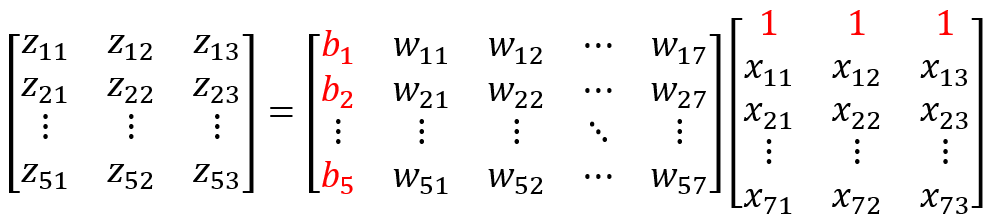

**Opdracht:** Lees opnieuw de file "backpropagation.txt" in, splits de data op in input `X` en output `Y`, en voeg vooraan een extra kolom met enen toe aan `X`. Dat laatste doe je op een generieke manier, d.w.z. het aantal rijen leid je af van de shape van `X`.

In [ ]:
import pandas as pd
import numpy as np

data = pd.read_csv("backpropagation.txt", header=None)
X = data.iloc[:, :7].values
X = np.concatenate((np.ones((X.shape[0], 1)), X), axis=1)
Y = data.iloc[:, 7:-1].values
print(X)
print(Y)

[[1.  0.3 0.4 0.8 0.9 0.2 0.2 0.5]
 [1.  0.5 0.1 0.5 0.8 0.3 0.7 0.3]
 [1.  0.9 0.2 0.1 0.1 0.3 0.3 0.8]
 [1.  0.6 0.3 0.5 0.9 1.  0.4 0.5]
 [1.  0.5 0.7 0.8 0.8 0.3 0.9 0.1]
 [1.  0.7 0.2 0.4 0.5 0.1 0.3 0.1]]
[[0 1 0]
 [1 0 0]
 [1 1 1]
 [0 0 1]
 [1 1 0]
 [0 0 0]]


In [ ]:
# de kolom met enen toevoegen kan ook op die manier:
data = pd.read_csv("backpropagation.txt", header=None)
X = np.ones((data.shape[0], 8))  # uiteindelijke matrix initialiseren met enen
X[:, 1:] = data.iloc[:, :7].values  # laatste 7 kolommen vervangen door de ingelezen data
print(X)

[[1.  0.3 0.4 0.8 0.9 0.2 0.2 0.5]
 [1.  0.5 0.1 0.5 0.8 0.3 0.7 0.3]
 [1.  0.9 0.2 0.1 0.1 0.3 0.3 0.8]
 [1.  0.6 0.3 0.5 0.9 1.  0.4 0.5]
 [1.  0.5 0.7 0.8 0.8 0.3 0.9 0.1]
 [1.  0.7 0.2 0.4 0.5 0.1 0.3 0.1]]


**Opdracht:** Pas nu het backpropagation algoritme aan zodat ook de bias term wordt afgeleid. Je hebt al de input uitgebreid met een extra kolom, nu moet je nog de matrices met gewichten `W` en de output matrices `A` van de tussenlagen uitbreiden. Concreet doe je nu het volgende:
- Kopieer de activatiefunctie `g` en afgeleide `dgdz`. Die moet je niet wijzigen.
- Kopieer de `predict` functie en voeg een extra rij met enen toe aan `A1`.
- Kopieer de `MSE` functie. Die blijft ook ongewijzigd.
- Kopieer de `backpropagation` functie. Ook hier krijgt `A1` een extra rij met enen. Bij de berekening van `D1` moet je de eerste kolom van `W2` weglaten.
- Kopieer tenslotte de code voor het toepassen van gradient descent. Hier moet je enkel `W1` en `W2` uitbreiden met een extra kolom bij het initialiseren.

Voer je code uit en plot de MSEs in functie van het aantal epochs. Convergeert het algoritme?

In [ ]:
# activatiefunctie blijft hetzelfde
g = lambda z: 1 / (1 + np.exp(-z))
dgdz = lambda z: g(z) * (1 - g(z))

# predict moet aangepast worden: A1 krijgt extra rij met enen
def predict(X, W1, W2, g):
    A1 = g(np.dot(W1, X.T))
    A1 = np.concatenate((np.ones((1, A1.shape[1])), A1), axis=0)  # output uitbreiden met extra rij
    return g(np.dot(W2, A1)).T

# MSE blijft hetzelfde
def MSE(X, Y, W1, W2, g):
    return np.mean(np.square(predict(X, W1, W2, g) - Y), axis=0)

In [ ]:
# backpropagation moet aangepast worden:
# - A1 krijgt extra rij met enen
# - eerste kolom van W2 wordt weggelaten bij berekening van D1
def backpropagation_batch(X, Y, W1, W2, g, dgdz, alpha):
    # forward
    A0 = X.T  # 8 x b
    Z1 = np.dot(W1, A0)  # (5 x 8) . (8 x b) -> 5 x b
    A1 = g(Z1)  # 5 x b
    A1 = np.concatenate((np.ones((1, A1.shape[1])), A1), axis=0)  # output uitbreiden met extra rij -> 6 x b
    Z2 = np.dot(W2, A1)  # (3 x 6) . (6 x b) -> 3 x b
    A2 = g(Z2)  # 3 x b
    # backward
    E = A2 - Y.T  # 3 x b
    D2 = E * dgdz(Z2)  # 3 x b
    D1 = np.dot(W2[:, 1:].T, D2) * dgdz(Z1)  # ((5 x 3) . (3 x b)) * (5 x b) -> 5 x b
    dW1 = np.dot(D1, A0.T)  # (5 x b) . (b x 8) -> 5 x 8
    dW2 = np.dot(D2, A1.T)  # (3 x b) . (b x 6) -> 3 x 6
    # new W1 and W2
    return W1 - alpha * dW1, W2 - alpha * dW2

In [ ]:
# gradient descent moet aangepast worden: W1 en W2 krijgen extra kolom
import random

# hyperparameters
alpha = 0.1
num_epochs = 5000
batch_size = 3

# aantal samples
nsamples = X.shape[0]

# gewichten initialiseren: beiden krijgen een extra kolom voor de bias!
W1, W2 = np.zeros((5, 8)), np.zeros((3, 6))  # bias op nul initialiseren
W1[:, 1:] = np.random.randn(5, 7)  # 8 ipv 7 kolommen!
W2[:, 1:] = np.random.randn(3, 5)  # 6 ipv 5 kolommen!
MSEs = []

# indices van datapunten
idx = np.array(range(nsamples))  # numpy array!

# outer loop: epochs
for _ in range(num_epochs):

    # batch shuffelen
    random.shuffle(idx)

    # initialize mini-batch indices
    b = np.arange(batch_size)

    # inner loop: mini-batches
    for i in range(nsamples // batch_size):  # integer division!

        # backpropagation voor mini-batch toepassen
        W1, W2 = backpropagation_batch(X=X[idx[b], :], Y=Y[idx[b], :],
                                       W1=W1, W2=W2, g=g, dgdz=dgdz, alpha=alpha)
        # update mini-batch indices
        b += batch_size

    # MSE
    MSEs.append(MSE(X, Y, W1, W2, g))

MSEs = np.asarray(MSEs)

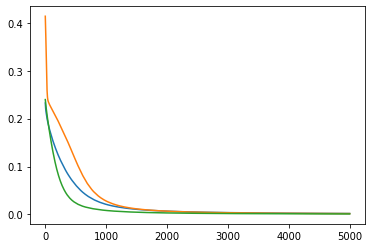

In [ ]:
# resultaat plotten
import matplotlib.pyplot as plt

plt.plot(MSEs);

## Implementing neural networks with K hidden layers

**UITDAGING**: Op basis van de uitleg die hierboven is gegeven moet het je nu lukken om een algemene klasse `NeuralNetwork` te schrijven waarbij het aantal lagen en nodes variabel is! En uiteraard breng je nu ook een bias-term in rekening en kunnen verschillende activatiefuncties worden toegepast. We leggen stap voor stap uit hoe je best te werk gaat.

*Gewichten initialiseren*

De matrices met gewichten stop je nu best in een list. De `k`-de matrix tussen laag `k` en `k+1` wordt als volgt geïnitialiseerd:

> `W[k] = np.random.randn(n2, n1+1)`

met `n2` het aantal nodes in laag `k+1` en `n1` het aantal nodes in laag `k`. Bemerk dat we een extra kolom voorzien voor de bias.

*Forward pass*

De forward pass bestaat nu uit een lus die de lagen van input naar output doorloopt. Ook hier stop je best de output matrices `Z` en `A` in een list. Je start met `A[0] = X.T` en je berekent dan `Z` en `A` van elke laag `k` als volgt:

> `Z[k] = np.dot(W[k], A[k])`

> `A[k+1] = g(Z[k])`

Vergeet niet om een extra rij met enen bovenaan `A[k+1]` toe te voegen.

*Backward pass*

De backward pass bestaat ook uit een lus maar die doorloopt de lagen van output naar input. Je start met de delta's van de laatste laag te berekenen:

> `D[-1] = (A[-1][1:, :] - Y.T) * dgdz(Z[-1])`

Je neemt dus de laatste `A` en `Z` matrix, je verwijdert de extra rij met enen uit matrix `A`. De delta's van de andere lagen bereken je als volgt:

> `D[k-1] = np.dot(W[k][:, 1:].T, D[k]) * dgdz(Z[k-1])`

Ook hier zie je dat bij de matrix met gewichten de eerste kolom wordt weggelaten.

*Gewichten aanpassen*

Tenslotte pas je de gewichten aan:

> `W[k] -= alpha * np.dot(D[k], A[k].T)`

*Opbouw klasse*

Definieer in je klasse een constructor die een list krijgt met het aantal nodes van de tussenlagen. Bijv.:

> `num_of_nodes = [6, 5, 4]`

Dit zou een neuraal netwerk definiëren met 3 tussenlagen van respectievelijk 6, 5 en 4 nodes. Op basis van die list kan je dan eenvoudig de gewichten initialiseren. Dit kan je doen in een (private) methode `__initialize_weights`

Geef ook de hyperparameters mee met de constructor: `alpha`, `num_of_epochs`, `batch_size`. En de activatiefunctie met zijn afgeleide. Je zou voor elke laag een aparte functie kunnen definiëren, maar je mag het eenvoudig houden, en één functie toepassen in alle lagen. Neem de sigmoïdefunctie als default.

De stappen die we hierboven hebben besproken komen in een (private) methode `__backpropagation`.

Dan heb je nog de methode `fit` nodig die het model gaat trainen door gradient descent toe te passen. Concreet gaat deze methode de gewichten initializeren en die dan aanpassen door het backpropagation algoritme `num_of_epochs` keer te doorlopen.

Tenslotte heb je ook de methoden `predict` en `MSE` nodig om de loss na elke epoch te berekenen en om voorspellingen te kunnen doen op nieuwe data. Om dat laatste te kunnen doen, moet je minstens de geoptimaliseerde gewichten bijhouden als attribuut!

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

In [ ]:
g = lambda z: 1 / (1 + np.exp(-z))
dgdz = lambda z: g(z) * (1 - g(z))

In [ ]:
class NeuralNetwork:

    def __init__(self, num_of_nodes, alpha, num_of_epochs, batch_size, activation=(g, dgdz)):
        # num_of_nodes is list with number of nodes in each hidden layer
        self.num_of_nodes = num_of_nodes
        self.nlayers = len(num_of_nodes) + 2
        self.g, self.dgdz = activation[0], activation[1]
        self.alpha = alpha
        self.num_of_epochs = num_of_epochs
        self.batch_size = batch_size
        self.W = None
        self.losses = None

    def __initialize_weights(self, X, Y):
        self.W = []
        n1 = X.shape[1] + 1
        for k in self.num_of_nodes:
            n2 = k
            self.W.append(np.random.randn(n2, n1))
            n1 = k + 1
        self.W.append(np.random.randn(Y.shape[1], n1))

    @staticmethod
    def __add_ones(M):
        # add row of ones on top of matrix M
        return np.concatenate((np.ones((1, M.shape[1])), M), axis=0)

    def __backpropagation(self, X, Y):
        # forward
        Z = []
        A = [self.__add_ones(X.T)]
        for k in range(self.nlayers - 1):
            Z.append(np.dot(self.W[k], A[k]))
            A.append(self.__add_ones(self.g(Z[k])))
        # backward
        E = A[-1][1:, :] - Y.T
        D = E * self.dgdz(Z[-1])
        for k in range(self.nlayers - 2, 0, -1):
            self.W[k] -= self.alpha * np.dot(D, A[k].T)
            D = np.dot(self.W[k][:, 1:].T, D) * self.dgdz(Z[k-1])
        self.W[0] -= self.alpha * np.dot(D, A[0].T)

    def fit(self, X, Y):

        # aantal samples
        nsamples = X.shape[0]

        # gewichten initialiseren
        self.__initialize_weights(X, Y)
        self.losses = []

        # indices van datapunten
        idx = np.array(range(nsamples))

        # outer loop: epochs
        for _ in range(self.num_of_epochs):

            # batch shuffelen
            random.shuffle(idx)

            # initialize mini-batch indices
            b = np.arange(self.batch_size)

            # inner loop: mini-batches
            for i in range(nsamples // self.batch_size):

                # backpropagation
                self.__backpropagation(X[idx[b], :], Y[idx[b], :])

                # update mini-batch indices
                b += self.batch_size

            # MSE
            self.losses.append(self.MSE(X, Y))

        self.losses = np.asarray(self.losses)

    def predict(self, X):
        A = self.__add_ones(X.T)
        for k in range(self.nlayers - 1):
            Z = np.dot(self.W[k], A)
            A = self.__add_ones(self.g(Z))
        return A[1:, :].T

    def MSE(self, X, Y):
        return np.mean(np.square(self.predict(X) - Y), axis=0)

Lees nu opnieuw de file "backpropagation.txt" in en test je code door hetzelfde model als in de vorige sectie te trainen op de data uit deze file.

In [ ]:
data = pd.read_csv("backpropagation.txt", header=None)
X = data.iloc[:, :7].values
Y = data.iloc[:, 7:-1].values
print(X)
print(Y)

[[0.3 0.4 0.8 0.9 0.2 0.2 0.5]
 [0.5 0.1 0.5 0.8 0.3 0.7 0.3]
 [0.9 0.2 0.1 0.1 0.3 0.3 0.8]
 [0.6 0.3 0.5 0.9 1.  0.4 0.5]
 [0.5 0.7 0.8 0.8 0.3 0.9 0.1]
 [0.7 0.2 0.4 0.5 0.1 0.3 0.1]]
[[0 1 0]
 [1 0 0]
 [1 1 1]
 [0 0 1]
 [1 1 0]
 [0 0 0]]


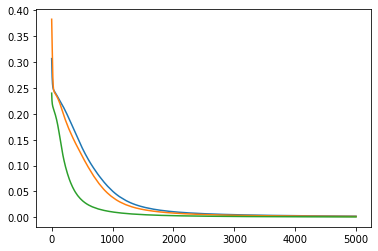

In [ ]:
model = NeuralNetwork([5], alpha=0.1, num_of_epochs=5000, batch_size=3)
model.fit(X, Y)
plt.plot(model.losses);

Definieer nu een model zonder tussenlaag en train het opnieuw op de ingelezen dataset. Krijg je nog steeds convergentie?

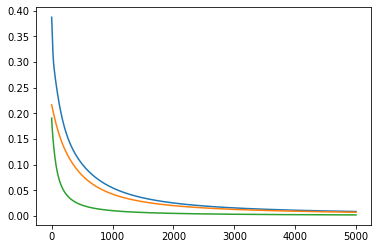

In [ ]:
model = NeuralNetwork([], alpha=0.1, num_of_epochs=5000, batch_size=3)
model.fit(X, Y)
plt.plot(model.losses);

Definieer tenslotte een model met 3 tussenlagen die respectievelijk 6, 5 en 4 nodes hebben. Train ook dit model op de ingelezen dataset. Wat merk je?

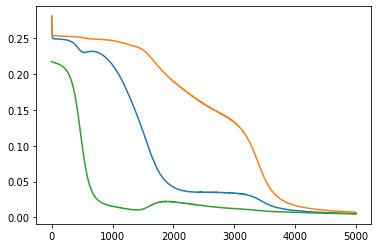

In [ ]:
model = NeuralNetwork([6, 5, 4], alpha=0.1, num_of_epochs=5000, batch_size=3)
model.fit(X, Y)
plt.plot(model.losses);

Speel ook eens met de hyperparameters. Het is vooral interessant om de learning rate eens te verhogen en te verlagen. Wat gebeurt er?

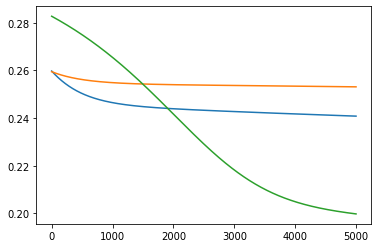

In [ ]:
# oorspronkelijke model (1 tussenlaag) en 100 x kleinere alpha
model = NeuralNetwork([5], alpha=0.001, num_of_epochs=5000, batch_size=3)
model.fit(X, Y)
plt.plot(model.losses);

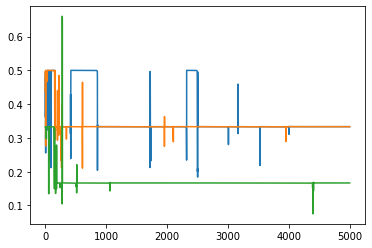

In [ ]:
# oorspronkelijke model (1 tussenlaag) en 100 x grotere alpha
model = NeuralNetwork([5], alpha=10, num_of_epochs=5000, batch_size=3)
model.fit(X, Y)
plt.plot(model.losses);

Denk je dat je bij de modellen die convergeren overfitting hebt? Waarom wel of waarom niet?

**Opdracht**

Een goeie oefening is nu om de klasse `NeuralNetwork` te refactoren. Laat je inspirireren door de Keras `Sequential` klasse en maak ook gebruik van een klasse `Layer`. Een `Sequential` object bevat een list van `Layer` objects, en een nieuwe `Layer` instantie kan je toevoegen via een methode `add`. Tijdens het trainen (methode `fit`) laat je elk `Layer` object de berekeningen uitvoeren van zijn eigen nodes. Je nieuwe code kan je uiteraard uittesten a.d.h.v. de code die we hierboven hebben ontwikkeld.

## Halloween Candy

De klasse die we hierboven hebben uitgewerkt kunnen we nu gebruiken om een neuraal netwerk te trainen op de Halloween Candy dataset (file "candy-data.csv"). Probeer bijvoorbeeld "winpercent" te voorspellen. Plot de voorspellingen uit tegenover de echte percentages, en bereken de RMSE. Is je model performant?

In [ ]:
data = pd.read_csv("candy-data.csv")
data

,competitorname,chocolate,fruity,caramel,peanutyalmondy,nougat,crispedricewafer,hard,bar,pluribus,sugarpercent,pricepercent,winpercent
0,100 Grand,1,0,1,0,0,1,0,1,0,0.732,0.860,66.971725
1,3 Musketeers,1,0,0,0,1,0,0,1,0,0.604,0.511,67.602936
2,One dime,0,0,0,0,0,0,0,0,0,0.011,0.116,32.261086
3,One quarter,0,0,0,0,0,0,0,0,0,0.011,0.511,46.116505
4,Air Heads,0,1,0,0,0,0,0,0,0,0.906,0.511,52.341465
...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,Twizzlers,0,1,0,0,0,0,0,0,0,0.220,0.116,45.466282
81,Warheads,0,1,0,0,0,0,1,0,0,0.093,0.116,39.011898
82,WelchÕs Fruit Snacks,0,1,0,0,0,0,0,0,1,0.313,0.313,44.375519
83,WertherÕs Original Caramel,0,0,1,0,0,0,1,0,0,0.186,0.267,41.904308


In [ ]:
Y = data.winpercent.values / 100
X = data.drop(labels=["competitorname", "winpercent"], axis=1).values

Text(0, 0.5, 'MSE')

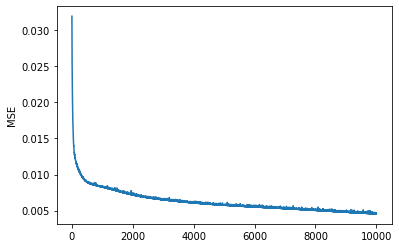

In [ ]:
model = NeuralNetwork([8, 5], alpha=0.1, num_of_epochs=10000, batch_size=17)
model.fit(X, Y.reshape(-1, 1))
plt.plot(model.losses);
plt.ylabel("MSE")

RMSE =  0.19


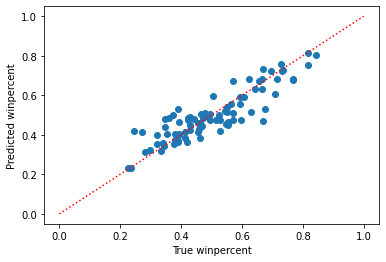

In [ ]:
Ypred = model.predict(X)
plt.scatter(Y, Ypred);
plt.plot([0, 1], [0, 1], 'r:');
plt.xlabel("True winpercent");
plt.ylabel("Predicted winpercent");
RMSE = np.sqrt(np.mean(np.square(Y-Ypred)))
print(f"RMSE = {RMSE: .2f}")

Probeer ook eens om de andere features te voorspellen en evalueer je resultaten met de juiste metrieken. Herhaal de oefening en maak deze keer gebruik van Keras om je modellen te bouwen.

## Topologies

De code die we hierboven stap voor stap hebben opgebouwd implementeert een zogenaamd **(Deep) Feed-Forward Neural Network**. Een Feed-Forward netwerk heeft één tussenlaag, terwijl een Deep Feed-Forward netwerk meerdere tussenlagen heeft en dus "dieper" is. Alle nodes tussen opeenvolgende lagen zijn met elkaar verbonden en elke laag kan een andere activatiefunctie toepassen.

De manier waarop de nodes met elkaar zijn verbonden noemt men de **topologie**. Uiteraard zijn er veel meer mogelijkheden dan de gelaagde stuctuur van de DFF netwerken. Hieronder zie je een overzicht van andere mogelijk topologieën. Merk op dat het backpropagation-algoritme niet toepasbaar is bij alle topologieën. Voor meer informatie verwijzen naar het artikel waaruit we deze figuur hebben gehaald:

https://towardsdatascience.com/the-mostly-complete-chart-of-neural-networks-explained-3fb6f2367464

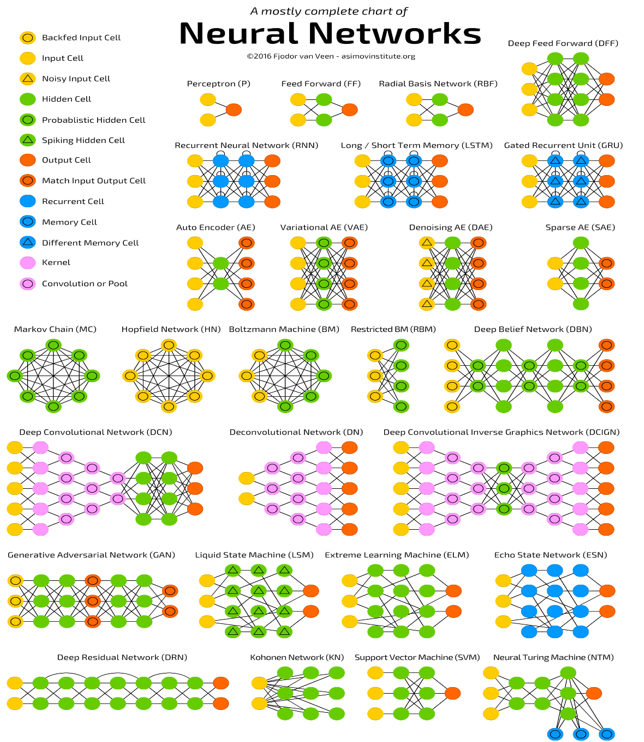

---